In [3]:
# After running this cell once, restart the kernel and run all the cells again
!pip install --upgrade fsspec
!pip install torchsummary
!pip install datasets
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 1.5 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.12.2
    Uninstalling fsspec-2023.12.2:
      Successfully uninstalled fsspec-2023.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.3.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.1.4 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you ha

In [4]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.models as models
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import math
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from torch.nn import Flatten

In [6]:
# import pytorch_lightning as pl
# import pl_bolts
# from pytorch_lightning.callbacks import ModelCheckpoint
# from pytorch_lightning.callbacks import LearningRateMonitor

# from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
# from pl_bolts.metrics import mean, accuracy

# from pl_bolts.models.self_supervised.evaluator import Flatten

Loading the Dataset

In [7]:
# from datasets import load_dataset
# dataset = load_dataset("jonathan-roberts1/PatternNet")
from datasets import load_dataset
dataset = load_dataset("blanchon/PatternNet")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/blanchon--PatternNet-dfbcf9378d867b46/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
dataset = dataset['train']

In [9]:
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 30400
})


In [10]:
# d_list = list(dataset)

# # Split the dataset list into train, test, and validation sets
# split_80,split_20 = train_test_split(d_list, test_size=0.2, random_state=42)

# # Extract images and labels from the dictionaries
# split_80_images, split_80_labels = zip(*[(item['image'], item['label']) for item in split_80])
# split_20_images, split_20_labels = zip(*[(item['image'], item['label']) for item in split_20])

# # Organize train data
# dataset = [{'image': image, 'label': label} for image, label in zip(split_80_images, split_80_labels)]
# # Organize test data
# test_20_split = [{'image': image, 'label': label} for image, label in zip(split_20_images, split_20_labels)]

In [11]:
prev_class=-1
curr_class = 0
num_elements = {}
start_class = {}
end_class = {}
for i in range(len(dataset)):
    if(dataset[i]['label']!=curr_class):
        end_class[curr_class] = i-1
    curr_class = dataset[i]['label']
    if(num_elements.get(curr_class)):
        num_elements[curr_class] += 1
#         if()
    else:
        num_elements[curr_class] = 1
        start_class[curr_class] = i

In [12]:
print(num_elements)
print(start_class)
end_class[37] = len(dataset)-1
print(end_class)

{0: 800, 1: 800, 2: 800, 3: 800, 4: 800, 5: 800, 6: 800, 7: 800, 8: 800, 9: 800, 10: 800, 11: 800, 12: 800, 13: 800, 14: 800, 15: 800, 16: 800, 17: 800, 18: 800, 19: 800, 20: 800, 21: 800, 22: 800, 23: 800, 24: 800, 25: 800, 26: 800, 27: 800, 28: 800, 29: 800, 30: 800, 31: 800, 32: 800, 33: 800, 34: 800, 35: 800, 36: 800, 37: 800}
{0: 0, 1: 800, 2: 1600, 3: 2400, 4: 3200, 5: 4000, 6: 4800, 7: 5600, 8: 6400, 9: 7200, 10: 8000, 11: 8800, 12: 9600, 13: 10400, 14: 11200, 15: 12000, 16: 12800, 17: 13600, 18: 14400, 19: 15200, 20: 16000, 21: 16800, 22: 17600, 23: 18400, 24: 19200, 25: 20000, 26: 20800, 27: 21600, 28: 22400, 29: 23200, 30: 24000, 31: 24800, 32: 25600, 33: 26400, 34: 27200, 35: 28000, 36: 28800, 37: 29600}
{0: 799, 1: 1599, 2: 2399, 3: 3199, 4: 3999, 5: 4799, 6: 5599, 7: 6399, 8: 7199, 9: 7999, 10: 8799, 11: 9599, 12: 10399, 13: 11199, 14: 11999, 15: 12799, 16: 13599, 17: 14399, 18: 15199, 19: 15999, 20: 16799, 21: 17599, 22: 18399, 23: 19199, 24: 19999, 25: 20799, 26: 21599, 

In [13]:
print(len(dataset)/(37*100))

8.216216216216216


In [14]:
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 30400
})


New Dataset with 10% of the total elements

In [15]:
import random
from datasets import Dataset
new_dataset = {'image':[],'label':[]}
for i in range(len(num_elements)):
    for j in range(90):
        a = random.randint(0,799)
        new_dataset['label'].append(dataset[start_class[i]+a]['label'])
        new_dataset['image'].append(dataset[start_class[i]+a]['image'])
new_dataset = Dataset.from_dict(new_dataset)
print(new_dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 3420
})


In [16]:
# percentage data of original data in new dataset
print(len(new_dataset)*100/len(dataset))

11.25


In [17]:
features = new_dataset['image']
labels = new_dataset['label']
dataset_list = list(new_dataset)

# Split the dataset list into train, test, and validation sets
train_data_new, test_val_data_new = train_test_split(dataset_list, test_size=0.4,stratify = labels, random_state=42)


# Extract images and labels from the dictionaries
train_images_new, train_labels_new = zip(*[(item['image'], item['label']) for item in train_data_new])
test_val_images_new, test_val_labels_new = zip(*[(item['image'], item['label']) for item in test_val_data_new])
# val_images_new, val_labels_new = zip(*[(item['image'], item['label']) for item in val_data_new])

In [18]:
# Organize train data
train_data_new = [{'image': image, 'label': label} for image, label in zip(train_images_new, train_labels_new)]
# Organize test data
test_val_data_new = [{'image': image, 'label': label} for image, label in zip(test_val_images_new, test_val_labels_new)]
# # Organize validation data
# val_data_new = [{'image': image, 'label': label} for image, label in zip(val_images_new, val_labels_new)]

In [19]:
test_val_data_new = {'image': [item['image'] for item in test_val_data_new],
             'label': [item['label'] for item in test_val_data_new]}

# Create a Hugging Face datasets.Dataset object
test_val_data_new = Dataset.from_dict(test_val_data_new)

In [20]:
print(test_val_data_new)

Dataset({
    features: ['image', 'label'],
    num_rows: 1368
})


In [21]:
features = test_val_data_new['image']
labels = test_val_data_new['label']
test_val_data_new_list = list(test_val_data_new)

test_data_new, val_data_new = train_test_split(test_val_data_new_list, test_size=0.5,stratify = labels, random_state=42)

test_images_new, test_labels_new = zip(*[(item['image'], item['label']) for item in test_data_new])
val_images_new, val_labels_new = zip(*[(item['image'], item['label']) for item in val_data_new])

# Organize test data
test_data_new = [{'image': image, 'label': label} for image, label in zip(test_images_new, test_labels_new)]
# Organize validation data
val_data_new = [{'image': image, 'label': label} for image, label in zip(val_images_new, val_labels_new)]

In [22]:
features = dataset['image']
labels = dataset['label']
dataset_list = list(dataset)
# Split the dataset list into train, test, and validation sets
dataset_list, _ = train_test_split(dataset_list, test_size=0.5,stratify = labels, random_state=42)
dataset_images, dataset_labels = zip(*[(item['image'], item['label']) for item in dataset_list])
dataset_data = [{'image': image, 'label': label} for image, label in zip(dataset_images, dataset_labels)]
dataset_data = {'image': [item['image'] for item in dataset_data],
             'label': [item['label'] for item in dataset_data]}

# Create a Hugging Face datasets.Dataset object
dataset_data = Dataset.from_dict(dataset_data)

In [23]:
features = dataset_data['image']
labels = dataset_data['label']
dataset_list = list(dataset_data)
# Split the dataset list into train, test, and validation sets
train_data, test_val_data = train_test_split(dataset_list, test_size=0.4,stratify = labels, random_state=42)
# Extract images and labels from the dictionaries
train_images, train_labels = zip(*[(item['image'], item['label']) for item in train_data])
test_val_images, test_val_labels = zip(*[(item['image'], item['label']) for item in test_val_data])
# val_images, val_labels = zip(*[(item['image'], item['label']) for item in val_data])

In [24]:
# Organize train data
train_data = [{'image': image, 'label': label} for image, label in zip(train_images, train_labels)]
# Organize test data
test_val_data = [{'image': image, 'label': label} for image, label in zip(test_val_images, test_val_labels)]
# # Organize validation data
# val_data = [{'image': image, 'label': label} for image, label in zip(val_images, val_labels)]

In [25]:
test_val_data = {'image': [item['image'] for item in test_val_data],
             'label': [item['label'] for item in test_val_data]}

# Create a Hugging Face datasets.Dataset object
test_val_data = Dataset.from_dict(test_val_data)

In [26]:
print(test_val_data)

Dataset({
    features: ['image', 'label'],
    num_rows: 6080
})


In [27]:
features = test_val_data['image']
labels = test_val_data['label']
test_val_data_list = list(test_val_data)
test_data, val_data = train_test_split(test_val_data_list, test_size=0.5,stratify = labels, random_state=42)

test_images, test_labels = zip(*[(item['image'], item['label']) for item in test_data])
val_images, val_labels = zip(*[(item['image'], item['label']) for item in val_data])

# Organize test data
test_data = [{'image': image, 'label': label} for image, label in zip(test_images, test_labels)]
# Organize validation data
val_data = [{'image': image, 'label': label} for image, label in zip(val_images, val_labels)]

In [28]:
print(len(train_data))
print(len(test_data))
print(len(val_data))

9120
3040
3040


In [29]:
from torchvision import transforms
to_tensor = transforms.ToTensor()

Transformations

In [30]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=256),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

DataLoader

In [31]:
class CustomDataset(Dataset):
  def __init__(self,original_dataset,transform=None):
    self.original_dataset=original_dataset
    self.transform=transform

  def __len__(self):
    return len(self.original_dataset)

  def __getitem__(self,index):
    image = self.original_dataset[index]['image']
    # image_triplet.append(image)
    img1 = self.transform(image)
    img2 = self.transform(image)
    # for i in range(2):
    #   augmented_image = self.transform(image)
    #   image_triplet.append(augmented_image)
    tensor_image = to_tensor(image)
    # image_triplet.append(tensor_image)
    return (img1, img2, tensor_image),self.original_dataset[index]['label']

In [32]:
d_train_new = CustomDataset(train_data_new,contrast_transforms)
d_test_new = CustomDataset(test_data_new,contrast_transforms)
d_val_new = CustomDataset(val_data_new,contrast_transforms)

In [33]:
batch_size = 4
shuffle = True
dataloader_train_new = DataLoader(d_train_new, batch_size=batch_size, shuffle=True)
dataloader_test_new = DataLoader(d_test_new, batch_size=batch_size, shuffle=True)
dataloader_val_new = DataLoader(d_val_new, batch_size=batch_size, shuffle=True)

In [34]:
d_train = CustomDataset(train_data,contrast_transforms)
d_test = CustomDataset(test_data,contrast_transforms)
d_val = CustomDataset(val_data,contrast_transforms)

In [35]:
batch_size = 4
shuffle = True
dataloader_train = DataLoader(d_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(d_test, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(d_val, batch_size=batch_size, shuffle=True)

Displaying some of the augmented images

Target shape: torch.Size([4])
torch.Size([4, 3, 256, 256])


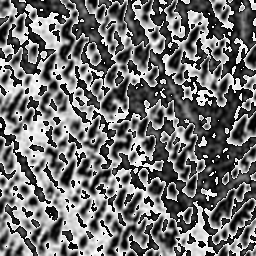

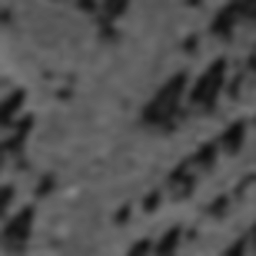

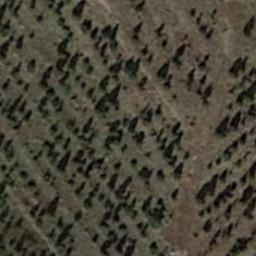

Targets: tensor([ 7, 36,  4, 35])


In [36]:
for batch in dataloader_train_new:
    # 'batch' contains the augmented and target images along with the label of the image
    inputs, targets = batch
    print("Target shape:", targets.shape)
    print(inputs[1].size())
    image1_np = transforms.ToPILImage()(inputs[0][0]).convert("RGB")
    display(image1_np)
    image1_np = transforms.ToPILImage()(inputs[1][0]).convert("RGB")
    display(image1_np)
    image1_np = transforms.ToPILImage()(inputs[2][0]).convert("RGB")
    display(image1_np)
    print("Targets:", targets)
    break

Loss Function

In [37]:
def nt_xent_loss(out_1, out_2, temperature):
    eps = 1e-8
    out = torch.cat([out_1, out_2], dim=0)
    n_samples = len(out)
#     print(out_1)
    # Full similarity matrix
    cov = torch.mm(out, out.t().contiguous())
    sim = torch.exp(cov / temperature)
    # print(sim)
    mask = ~torch.eye(n_samples, device=sim.device).bool()
    neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)
    # Positive similarity
    pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)
    loss = -torch.log((pos / neg)+eps).mean()
    return loss

Specifying the Model architecture

In [36]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])
up_sample_model = nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(512,2048, kernel_size=1),nn.BatchNorm2d(2048),nn.ReLU())
projection_model = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.BatchNorm1d(2048),nn.Linear(2048,2048,bias=True),nn.ReLU(),nn.Linear(2048,128,bias=False))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s] 


In [37]:
model = nn.Sequential(resnet18,up_sample_model,projection_model)

In [38]:
dummy_input = torch.randn((4, 3, 256, 256))
# print(model(dummy_input))

tensor([[-0.0573,  0.0070, -0.1251, -0.0922,  0.3980, -0.3977, -0.4323,  0.4432,
         -0.0575,  0.1713,  0.0042,  0.0025, -0.2152, -0.0171, -0.0016,  0.5838,
          0.1430, -0.0950, -0.3040, -0.0565, -0.0702, -0.4535, -0.1427, -0.0355,
          0.0134,  0.1181,  0.2209,  0.0079,  0.2461, -0.2800,  0.3194,  0.0901,
          0.0194, -0.0684, -0.4320, -0.2086, -0.2169,  0.1160, -0.3391,  0.3829,
          0.2040, -0.3037, -0.3889,  0.4049, -0.0171, -0.0415, -0.0675,  0.1859,
          0.1803,  0.1685, -0.1197,  0.0387,  0.2530,  0.2607, -0.1141,  0.2089,
         -0.0158, -0.4036,  0.2809, -0.0881, -0.0039,  0.6690,  0.2436,  0.2173,
          0.0717, -0.5130,  0.1987, -0.2840,  0.0451, -0.0388, -0.2099, -0.3277,
         -0.0538,  0.0163, -0.1730,  0.1539,  0.2947,  0.0299,  0.0422,  0.2945,
          0.3582,  0.4922, -0.2428,  0.0702, -0.1205,  0.0037,  0.1191,  0.0396,
         -0.1988,  0.1166, -0.1751,  0.2976, -0.4712,  0.2372,  0.4563, -0.0130,
          0.1843, -0.0265, -

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [40]:
device_of_model = next(model.parameters()).device
print("Model is on:", device_of_model)

Model is on: cuda:0


In [41]:
optimizer = optim.Adam(model.parameters(), lr=0.000001, weight_decay=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [42]:
from tqdm import tqdm

SimCLR Trainig 

In [43]:
from tqdm.notebook import tqdm  # Import tqdm from tqdm.notebook for Jupyter environments
epochs = 4
no = 0
a = 0
losses = []
# Create a single progress bar for the entire training loop
pbar = tqdm(total=len(dataloader_train) * epochs, desc=f"Epoch {no + 1}/{epochs}")

Epoch 1/4:   0%|          | 0/9120 [00:00<?, ?it/s]

In [44]:
epochs=4
no=0
a=0
losses=[]
for epoch in range(epochs):
  loss=0
  net_loss=0
  model.train()
  print("\n")
  print("training"+str(no+1)+"/"+str(epochs))  # Print epoch information
  for step, batch in enumerate(tqdm(dataloader_train, desc=f"Epoch {epoch + 1}/{epochs}")):
    t_in1,t_labels=batch
    t_in1[0] = t_in1[0].to(device)
    t_in1[1] = t_in1[1].to(device)
    t_in1[2] = t_in1[2].to(device)
    t_labels = t_labels.to(device)
    # print(t_in1.size())
    # print(t_in2.size())
    output1=model(t_in1[0])
    output2=model(t_in1[1])
#     print(output1)
    model.zero_grad()
    loss=nt_xent_loss(output1,output2,0.5)
#     print(loss)
    net_loss+=loss.item()
    loss.backward()
    optimizer.step()
    pbar.update(1)
  scheduler.step()
  avg_epoch_loss=net_loss/len(dataloader_train)
  losses.append(avg_epoch_loss)
  no+=1
  print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_epoch_loss:.4f}")
  pbar.set_postfix_str("Validation")
  print("Validation")
  model.eval()
  eval_acc_temp=0
  eval_acc=0
  eval_steps=0

  for batch in dataloader_val:
      # batch=tuple(t.to(device) for t in batch)
      t_in1,t_labels=batch
      t_in1[0] = t_in1[0].to(device)
      t_in1[1] = t_in1[1].to(device)
      t_in1[2] = t_in1[2].to(device)
      t_labels = t_labels.to(device)

      output1=model(t_in1[0])
      output2=model(t_in1[1])
      # print(output1)
      eval_acc_temp=nt_xent_loss(output1,output2,0.5)
      eval_acc+=eval_acc_temp.item()
      eval_steps+=1
      acc=eval_acc/eval_steps
  print("validation loss is "+str(acc))
pbar.close()



training1/4


Epoch 1/4:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [1/4] - Loss: 0.4488
Validation
validation loss is 0.757510532578147


training2/4


Epoch 2/4:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [2/4] - Loss: 0.2461
Validation
validation loss is 0.7032019555229693


training3/4


Epoch 3/4:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [3/4] - Loss: 0.1943
Validation
validation loss is 0.5841287453316526


training4/4


Epoch 4/4:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [4/4] - Loss: 0.1529
Validation
validation loss is 0.46814119395965365


Linear Evaluation 

In [45]:
for param in resnet18.parameters():
    param.requires_grad = False

Classification Layer

In [56]:
classification_layer=nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.BatchNorm1d(512),nn.Linear(512,512,bias=True),nn.ReLU(),nn.Linear(512,38,bias=False))

In [57]:
dummy_input = torch.randn((16,512,1,1))
# print(classification_layer(dummy_input).size())

torch.Size([16, 38])


In [58]:
final_model = nn.Sequential(resnet18,classification_layer)

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = final_model.to(device)
summary(final_model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [50]:
def ce(out,label):
    return F.cross_entropy(out,label)

In [61]:
optimizer2 = optim.Adam(final_model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler2 = CosineAnnealingLR(optimizer2, T_max=10, eta_min=0)

In [62]:
epochs = 11
no = 0
a = 0
losses = []
# Create a single progress bar for the entire training loop
pbar = tqdm(total=len(dataloader_train) * epochs, desc=f"Epoch {no + 1}/{epochs}")

Epoch 1/11:   0%|          | 0/25080 [00:00<?, ?it/s]

In [63]:
no=0
a=0
losses=[]
for epoch in range(epochs):
  loss=0
  net_loss=0
  final_model.train()
  print("\n")
  print("training"+str(no+1)+"/"+str(epochs))  # Print epoch information
  for step, batch in enumerate(tqdm(dataloader_train_new, desc=f"Epoch {epoch + 1}/{epochs}")):
    t_in1,t_labels=batch
    t_in1[2] = t_in1[2].to(device)
    t_labels = t_labels.to(device)
    output = final_model(t_in1[2])
    final_model.zero_grad()
    loss=ce(output,t_labels)
    net_loss+=loss.item()
    loss.backward()
    optimizer2.step()
    pbar.update(1)
  scheduler2.step()
  avg_epoch_loss=net_loss/len(dataloader_train_new)
  losses.append(avg_epoch_loss)
  no+=1
  print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_epoch_loss:.4f}")
  pbar.set_postfix_str("Validation")
  print("Validation")
  final_model.eval()
  eval_loss_temp=0
  eval_loss=0
  eval_steps=0
  correct_pred = 0
  total_pred = 0
  accuracy = 0
  for batch in dataloader_val_new:
      t_in1,t_labels=batch
      t_in1[2] = t_in1[2].to(device)
      t_labels = t_labels.to(device)
      output = final_model(t_in1[2])
      # print(output1)
      eval_loss_temp=ce(output,t_labels)
      eval_loss+=eval_loss_temp.item()
      eval_steps+=1
      acc=eval_loss/eval_steps
      _,predicted_class = torch.max(output,1)
      correct_pred += (predicted_class == t_labels).sum().item()
      total_pred += t_labels.size(0)
  print("Validation loss is "+str(acc))
  accuracy = (correct_pred/total_pred)*100
  print("Validation accuracy is "+str(accuracy)+"%")
pbar.close()



training1/11


Epoch 1/11:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch [1/11] - Loss: 1.2171
Validation
Validation loss is 0.2869535228526846
Validation accuracy is 89.76608187134502%


training2/11


Epoch 2/11:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch [2/11] - Loss: 0.5839
Validation
Validation loss is 0.2881206642523892
Validation accuracy is 92.39766081871345%


training3/11


Epoch 3/11:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch [3/11] - Loss: 0.4555
Validation
Validation loss is 0.2625965432134896
Validation accuracy is 91.95906432748538%


training4/11


Epoch 4/11:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch [4/11] - Loss: 0.4278
Validation
Validation loss is 0.23646402857354312
Validation accuracy is 93.85964912280701%


training5/11


Epoch 5/11:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch [5/11] - Loss: 0.3517
Validation
Validation loss is 0.20959646393536152
Validation accuracy is 94.15204678362574%


training6/11


Epoch 6/11:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch [6/11] - Loss: 0.2636
Validation
Validation loss is 0.14575071624303831
Validation accuracy is 95.02923976608187%


training7/11


Epoch 7/11:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch [7/11] - Loss: 0.2455
Validation
Validation loss is 0.1626805156332221
Validation accuracy is 95.46783625730994%


training8/11


Epoch 8/11:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch [8/11] - Loss: 0.2134
Validation
Validation loss is 0.1428807442195206
Validation accuracy is 95.32163742690058%


training9/11


Epoch 9/11:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch [9/11] - Loss: 0.1660
Validation
Validation loss is 0.12127830643957672
Validation accuracy is 96.19883040935673%


training10/11


Epoch 10/11:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch [10/11] - Loss: 0.1721
Validation
Validation loss is 0.15282396817752864
Validation accuracy is 95.17543859649122%


training11/11


Epoch 11/11:   0%|          | 0/513 [00:00<?, ?it/s]

Epoch [11/11] - Loss: 0.1784
Validation
Validation loss is 0.13927589161645276
Validation accuracy is 95.32163742690058%


In [64]:
for batch in dataloader_train_new:
    img,label = batch
    img[2] = img[2].to(device)
    label = label.to(device)
    out1 = final_model(img[2])
    _,predicted_class = torch.max(out1,1)
    print(predicted_class)
    print(label)
    break

tensor([23, 33, 14, 31], device='cuda:0')
tensor([23, 33, 14, 31], device='cuda:0')


In [65]:
print("Test")
final_model.eval()
test_loss_temp=0
test_loss=0
test_steps=0
correct_pred = 0
total_pred = 0
accuracy = 0
for batch in dataloader_test_new:
  # batch=tuple(t.to(device) for t in batch)
  t_in1,t_labels=batch
#       t_in1[0] = t_in1[0].to(device)
#       t_in1[1] = t_in1[1].to(device)
  t_in1[2] = t_in1[2].to(device)
  t_labels = t_labels.to(device)
  output = final_model(t_in1[2])
  # print(output1)
  test_loss_temp=ce(output,t_labels)
  test_loss+=test_loss_temp.item()
  test_steps+=1
  acc=test_loss/test_steps
  _,predicted_class = torch.max(output,1)
  correct_pred += (predicted_class == t_labels).sum().item()
  total_pred += t_labels.size(0)
print("Test loss is "+str(acc))
accuracy = (correct_pred/total_pred)*100
print("Test accuracy is "+str(accuracy)+"%")

Test
Test loss is 0.17993905318298078
Test accuracy is 95.32163742690058%


In [38]:
resnet18_2 = torchvision.models.resnet18(pretrained=True)
resnet18_2 = nn.Sequential(*list(resnet18_2.children())[:-1])
up_sample_model_2 = nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(512,2048, kernel_size=1),nn.BatchNorm2d(2048),nn.ReLU())
projection_model_2 = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.BatchNorm1d(2048),nn.Linear(2048,2048,bias=True),nn.ReLU(),nn.Linear(2048,128,bias=False))
model_2 = nn.Sequential(resnet18_2,up_sample_model_2,projection_model_2)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s] 


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = model_2.to(device)
summary(model_2, input_size=(3, 256, 256))
device_of_model = next(model_2.parameters()).device
print("Model is on:", device_of_model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [43]:
for param in resnet18_2.parameters():
    param.requires_grad = True
classification_layer_2=nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.BatchNorm1d(512),nn.Linear(512,512,bias=True),nn.ReLU(),nn.Linear(512,38,bias=False))

In [44]:
final_model_2 = nn.Sequential(resnet18_2,classification_layer_2)

In [45]:
optimizer2 = optim.Adam(final_model_2.parameters(), lr=0.000001, weight_decay=1e-6)
scheduler2 = CosineAnnealingLR(optimizer2, T_max=10, eta_min=0)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model_2 = final_model_2.to(device)
summary(final_model_2, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [48]:
from tqdm.notebook import tqdm  # Import tqdm from tqdm.notebook for Jupyter environments
epochs = 11
no = 0
a = 0
losses = []
# Create a single progress bar for the entire training loop
pbar = tqdm(total=len(dataloader_train) * epochs, desc=f"Epoch {no + 1}/{epochs}")

Epoch 1/11:   0%|          | 0/25080 [00:00<?, ?it/s]

In [51]:
no=0
a=0
losses=[]
for epoch in range(epochs):
  loss=0
  net_loss=0
  final_model_2.train()
  print("\n")
  print("training"+str(no+1)+"/"+str(epochs))  # Print epoch information
  for step, batch in enumerate(tqdm(dataloader_train, desc=f"Epoch {epoch + 1}/{epochs}")):
    t_in1,t_labels=batch
    t_in1[2] = t_in1[2].to(device)
    t_labels = t_labels.to(device)
    output = final_model_2(t_in1[2])
    final_model_2.zero_grad()
    loss=ce(output,t_labels)
    net_loss+=loss.item()
    loss.backward()
    optimizer2.step()
    pbar.update(1)
  scheduler2.step()
  avg_epoch_loss=net_loss/len(dataloader_train)
  losses.append(avg_epoch_loss)
  no+=1
  print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_epoch_loss:.4f}")
  pbar.set_postfix_str("Validation")
  print("Validation")
  final_model_2.eval()
  eval_loss_temp=0
  eval_loss=0
  eval_steps=0
  correct_pred = 0
  total_pred = 0
  accuracy = 0
  for batch in dataloader_val:
      t_in1,t_labels=batch
      t_in1[2] = t_in1[2].to(device)
      t_labels = t_labels.to(device)
      output = final_model_2(t_in1[2])
      # print(output1)
      eval_loss_temp=ce(output,t_labels)
      eval_loss+=eval_loss_temp.item()
      eval_steps+=1
      acc=eval_loss/eval_steps
      _,predicted_class = torch.max(output,1)
      correct_pred += (predicted_class == t_labels).sum().item()
      total_pred += t_labels.size(0)
  print("Validation loss is "+str(acc))
  accuracy = (correct_pred/total_pred)*100
  print("Validation accuracy is "+str(accuracy)+"%")
pbar.close()



training1/11


Epoch 1/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [1/11] - Loss: 3.5412
Validation
Validation loss is 3.3586007717408632
Validation accuracy is 20.559210526315788%


training2/11


Epoch 2/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [2/11] - Loss: 3.3197
Validation
Validation loss is 3.073896846332048
Validation accuracy is 45.78947368421053%


training3/11


Epoch 3/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [3/11] - Loss: 3.1079
Validation
Validation loss is 2.7950888385898187
Validation accuracy is 62.10526315789474%


training4/11


Epoch 4/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [4/11] - Loss: 2.9219
Validation
Validation loss is 2.5814082531552565
Validation accuracy is 66.61184210526315%


training5/11


Epoch 5/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [5/11] - Loss: 2.7660
Validation
Validation loss is 2.3340913054190184
Validation accuracy is 73.51973684210526%


training6/11


Epoch 6/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [6/11] - Loss: 2.6399
Validation
Validation loss is 2.2350251793077116
Validation accuracy is 76.84210526315789%


training7/11


Epoch 7/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [7/11] - Loss: 2.5519
Validation
Validation loss is 2.109692995642361
Validation accuracy is 77.73026315789474%


training8/11


Epoch 8/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [8/11] - Loss: 2.4897
Validation
Validation loss is 2.0358218646363206
Validation accuracy is 80.5592105263158%


training9/11


Epoch 9/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [9/11] - Loss: 2.4659
Validation
Validation loss is 2.030264285755785
Validation accuracy is 78.7828947368421%


training10/11


Epoch 10/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [10/11] - Loss: 2.4504
Validation
Validation loss is 2.0072662708006406
Validation accuracy is 80.65789473684211%


training11/11


Epoch 11/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [11/11] - Loss: 2.4529
Validation
Validation loss is 2.02008181700581
Validation accuracy is 81.71052631578948%


In [52]:
print("Test")
final_model_2.eval()
test_loss_temp=0
test_loss=0
test_steps=0
correct_pred = 0
total_pred = 0
accuracy = 0
for batch in dataloader_test:
  # batch=tuple(t.to(device) for t in batch)
  t_in1,t_labels=batch
#       t_in1[0] = t_in1[0].to(device)
#       t_in1[1] = t_in1[1].to(device)
  t_in1[2] = t_in1[2].to(device)
  t_labels = t_labels.to(device)
  output = final_model_2(t_in1[2])
  # print(output1)
  test_loss_temp=ce(output,t_labels)
  test_loss+=test_loss_temp.item()
  test_steps+=1
  acc=test_loss/test_steps
  _,predicted_class = torch.max(output,1)
  correct_pred += (predicted_class == t_labels).sum().item()
  total_pred += t_labels.size(0)
print("Test loss is "+str(acc))
accuracy = (correct_pred/total_pred)*100
print("Test accuracy is "+str(accuracy)+"%")

Test
Test loss is 2.02167365464725
Test accuracy is 81.67763157894737%
